In [1]:
root="C:/github/RatDeconvolution"

# Clustering

In [2]:
import warnings
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import statsmodels.stats.multitest as sm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import manifold
import umap

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = 18
warnings.simplefilter('ignore')

In [3]:
'''
Starter code for Python implementation of meta-visualization
reference: Eric Sun (2022)
https://github.com/rongstat/meta-visualization/blob/main/Python%20Code/meta_visualization.py

'''
    
def meta_viz(visualizations, projection_method=None):
    '''
    Inputs:
       visualizations [list of numpy arrays]
        - list of numpy arrays of size n x 2 (columns being the two-dimensional coordinates of visualization)
        - each row should be matched to the same observation/sample across all elements in the list
       projection_method [str or None]
        - options are "tSNE" or "MDS" for reprojecting the meta-distance matrix into a meta-visualization
    
    Approach:
        1. Computes euclidean distance matrices from 2D embeddings
        2. Ensembles the euclidean distance according to eigenvector with largest eigenvalue
        3. Uses projection_method ["MDS", "tSNE"] to transform euclidean distance matrix to 2D embeddings
        
    Returns:
        meta_visualization [numpy array] - size nx2 two-dimensional visualization genereated using the meta-visualization approach
            - returned only if projection_method is not None
        meta_distances [numpy array] - size nxn pairwise euclidean distance matrix generated using meta-visualization approach
    '''
    # define number of samples
    n = visualizations[0].shape[0]
    K = len(visualizations)
    
    # Iterate and record distance matrices
    X_distance_matrix_list = []
    
    # compute pairwise distance matrix
    for X_embedded in visualizations:
        assert X_embedded.shape[0] == n, "All visualization arrays need to have the same number of rows"
        assert X_embedded.shape[1] == 2, "All visualization arrays need to have two columns"
        X_distance = metrics.pairwise_distances(X_embedded)
        X_distance_matrix_list.append(X_distance)
             
    # Compute weights for meta-visualization
    meta_distances = np.zeros((n,n))
    weights = np.zeros((n,K))
    for j in range(n):
        # fill in comparison matrix
        comp_mat = np.zeros((K,K))
        for i in range(K):
            for k in range(K):
                comp_mat[i,k] = np.sum(X_distance_matrix_list[k][:,j]*X_distance_matrix_list[i][:,j])/np.sqrt(np.sum(X_distance_matrix_list[k][:,j]**2))/np.sqrt(np.sum(X_distance_matrix_list[i][:,j]**2))
        # Eigenscore
        w, v = np.linalg.eig(comp_mat)
        weights[j,:] = np.abs(v[:,0])
    
        # Ensembles distance matrices
        matrix_norms = []
        for i in range(K):
            matrix_norms.append(X_distance_matrix_list[i][:,j]/np.sqrt(np.sum(X_distance_matrix_list[i][:,j]**2)))
        
        temp = np.zeros(matrix_norms[0].shape)
        for i in range(K):
            temp += matrix_norms[i]*weights[j,i]
            
        meta_distances[:,j] = temp
    
    meta_distances = np.nan_to_num((meta_distances+meta_distances.T)/2)
    
    # Re-project on 2D embedding space
    if projection_method is None:
        return(meta_distances)
    else:
        if projection_method == "tSNE":
            tsne = manifold.TSNE(n_components=2, metric="precomputed", verbose=0).fit(meta_distances)
            meta_visualization = tsne.embedding_
        elif projection_method == "MDS":
            mds = manifold.MDS(n_components=2, verbose=0, dissimilarity="precomputed").fit(meta_distances)
            meta_visualization = mds.embedding_
    
        return(meta_visualization, meta_distances)

In [4]:
def calc_z(res, drugs=list(), ctrl:str="Control"):
    df_z = pd.DataFrame(columns=res.columns.tolist())
    for drug in drugs:
        res_temp = res.loc[res.index.str.contains(drug),:]
        res_ctrl = res_temp.loc[res_temp.index.str.contains(ctrl),:]
        res_drug = res_temp.loc[~res_temp.index.str.contains(ctrl),:]
        
        mean = np.nanmean(res_ctrl.values,axis=0)
        std = np.nanstd(res_ctrl.values,axis=0)
        res_z = pd.DataFrame((res_drug.values - mean)/std)
        res_z.index = res_drug.index
        res_z.columns = res_drug.columns
        res_z = res_z.replace(np.inf,0)
        res_z = res_z.replace(-np.inf,0)
        res_z = res_z.fillna(0)
        if len(res.index)!=0:
            df_z = pd.concat([df_z, res_z],axis=0)
    return df_z

def annotation_sample(df, df_b):
    temp = df_b.loc[df.columns.tolist()]
    name = temp["COMPOUND_NAME"].tolist()
    dose = temp["DOSE_LEVEL"].tolist()
    time = temp["SACRIFICE_PERIOD"].tolist()
    ind = [f"{i}_{j}_{k}" for i, j, k in zip(name, dose, time)]
    return ind

def abs_threshold(df, threshold=10.0):
    df = df[df<threshold].fillna(threshold)
    df = df[df>-threshold].fillna(-threshold)
    return df

def load(target_compounds, mean=True):
    # Deconvolution
    df_alt = pd.read_csv(f"{root}/data/tggate_biochemical_values.csv", index_col=0)
    df_alt = calc_z(df_alt.T, drugs=target_compounds, ctrl="ctrl")
    df_alt.index = [i.split("_rep")[0] for i in df_alt.index]
    df_alt = df_alt.loc[:,['ALT(IU/L)',]]
    df_alt.columns = ["ALT"]
    df_alt.index=[i.split(" h")[0] + " hr" for i in df_alt.index]
    if mean:
        df_alt = df_alt.groupby(level=0,axis=0).mean()

    df = pd.read_csv(f"{root}/result/tggate_result.csv", index_col=0)
    df = df.loc[(df.index.str.contains("High")) | (df.index.str.contains("Control")),:]
    df = df.loc[~(df.index.str.contains("day")),:]
    df_z = calc_z(df, drugs=target_compounds, ctrl="Control")
    if mean:
        df_z = df_z.groupby(axis=0, level=0).mean()
    return df_z, df_alt

def load_transcriptome(target_compounds, mean=True):
    # load transcriptome
    df_target = pd.read_csv(f"{root}/data/tggate_transcriptome.csv",index_col=0)
    df_sample = pd.read_csv(f"{root}/data/tggate_sample_information.csv",index_col=0)
    df_target.columns=[str(i) for i in df_target.columns]
    df_sample.index=[str(i) for i in df_sample.index]
    df_target.columns = annotation_sample(df_target, df_sample)
    target_lst = [
        f'{compound}_{conc}_{time}'
        for compound in target_compounds 
        for conc in ["High", "Control"]
        for time in ["3 hr", "6 hr", "9 hr", "24 hr"]
    ]
    df_target=df_target.loc[:,target_lst]
    df_target = abs_threshold(np.log2(df_target+1), threshold=10.0)
    if mean:
        df_target = df_target.groupby(axis=1, level=0).mean()
    return df_target

def create_table(df, target_compounds, preprocessing=None, pros_lst=True):
    times = ["3 hr", "6 hr", "9 hr", "24 hr"]
    lst_features = []
    for feat in df.columns:
        lst_features.extend([f"{feat}_{time}" for time in times])

    df_time = pd.DataFrame(index=lst_features, columns=target_compounds)
    for comp in target_compounds:
        lst_feat_all = []
        for feat in df.columns:
            lst_feat = df.loc[[f"{comp}_High_{time}" for time in times],feat].tolist()
            if pros_lst:
                lst_feat = preprocessing(lst_feat)
            lst_feat_all.extend(lst_feat)
        df_time[comp]=lst_feat_all
    df_time = df_time.T
    if not pros_lst:
        df_time= df_time.apply(preprocessing)
    return df_time

def minmax(lst):
    scaler = MinMaxScaler()
    return [i[0] for i in list(scaler.fit_transform(np.array(lst).reshape(-1, 1)))]

def max_one(lst):
    return [i/max(lst) for i in lst]

def raw(lst):
    return lst

def z_conv(lst):
    scaler = StandardScaler()
    return [i[0] for i in list(scaler.fit_transform(np.array(lst).reshape(-1, 1)))]



In [5]:
def meta_viz_calc(df, random_state=24771):
    model = manifold.LocallyLinearEmbedding(method="standard", random_state=random_state)
    x_embedded_lle=model.fit_transform(df.values)
    model =  manifold.MDS(n_components=2, max_iter=50, n_init=4, random_state=random_state)
    x_embedded_mds = model.fit_transform(df.values)
    model = manifold.SpectralEmbedding(n_components=2, n_neighbors=2, random_state=random_state)
    x_embedded_spc = model.fit_transform(df.values)
    model = PCA(n_components=2, random_state=random_state)
    x_embedded_pca = model.fit_transform(df.values)
    model = manifold.TSNE(n_components=2, perplexity=2, random_state=random_state)
    x_embedded_tsne = model.fit_transform(df.values)
    model = umap.UMAP(n_components=2, random_state=random_state, n_neighbors=2)
    x_embedded_umap = model.fit_transform(df.values)
    meta_visualization, meta_distances = meta_viz([x_embedded_lle, x_embedded_mds, x_embedded_spc, x_embedded_pca, x_embedded_tsne, x_embedded_umap], projection_method="MDS")
    return meta_visualization, meta_distances

def plot_meta(df_time, meta_visualization, lst_cluster, figname=None):
    colors= ["firebrick", "darkblue", "darkgreen", "darkviolet"]
    df_meta = pd.DataFrame(index=df_time.index.tolist())
    df_meta["Cluster_ID"]=lst_cluster
    df_meta["META_0"]=meta_visualization.T[0]
    df_meta["META_1"]=meta_visualization.T[1]
    fig = plt.figure(figsize=(5,4))
    ax=fig.add_subplot(111) 
    for i, color in enumerate(colors):
        df_temp=df_meta[df_meta["Cluster_ID"]==i]
        ax.scatter(
            df_temp["META_0"], df_temp["META_1"],
            s=70, marker="o", 
            color="w", alpha=1,
            linewidth=3, ec=color,
            )
    ax.set_title(f"META Visualization")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.tight_layout()
    if figname:
        plt.savefig(figname, dpi=300)
    plt.show()   

def plot_cluster(df_time, meta_distances, lst_cluster, col, row_colors=None, figname=None):
    df_meta_plt=pd.DataFrame(meta_distances, index=df_time.index, columns=df_time.index)
    color_cluster=["firebrick", "darkblue", "darkgreen", "darkviolet"]
    if row_colors is None:
        row_colors=[color_cluster[i] for i in lst_cluster]
    linkage = hc.linkage(sp.distance.squareform(meta_distances), method='average')
    plt_cluster = sns.clustermap(
        df_meta_plt.loc[:,col],
        figsize=(9,8),
        col_cluster=False,
        row_linkage=linkage,
        col_linkage=linkage,
        row_colors=row_colors,
        cbar_pos=None,
        cmap="PuOr",
        )
    ax = plt_cluster.ax_heatmap
    ax.set_xticklabels([])
    plt.tight_layout()
    if figname:
        plt.savefig(figname, dpi=300)
    plt.show()

In [6]:
target_compounds=[
    "naphthyl isothiocyanate","bromobenzene","simvastatin","enalapril",
    "gefitinib","metformin","tiopronin","colchicine",
    "bortezomib","methylene dianiline","galactosamine","thioacetamide",
    "LPS","cycloheximide","tacrine","nitrofurazone",
    ]

clusters = [
    ["naphthyl isothiocyanate","bromobenzene","simvastatin","enalapril","gefitinib","metformin","tiopronin",],
    ["colchicine","bortezomib","methylene dianiline","galactosamine","thioacetamide",],
    ["LPS","cycloheximide"],["tacrine","nitrofurazone"],
]

lst_target = [
    "Neu",
    "Mon",
    "CD4T",
    "CD8T",
]

## Immune Clustering

In [17]:
df, _ = load(target_compounds)
df = df.loc[:,lst_target]
df_time = create_table(df, target_compounds, preprocessing=raw, pros_lst=False)
df_time = df_time.loc[clusters[0]+clusters[1]+clusters[2]+clusters[3],:]
lst_cluster=[0]*len(clusters[0])+[1]*len(clusters[1])+[2]*len(clusters[2])+[3]*len(clusters[3])


In [18]:
meta_visualization, meta_distances = meta_viz_calc(df_time)

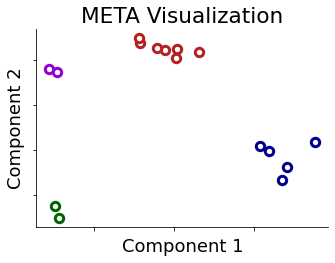

In [19]:
plot_meta(df_time, meta_visualization, lst_cluster, figname=f"{root}/figures/fig4a.png")

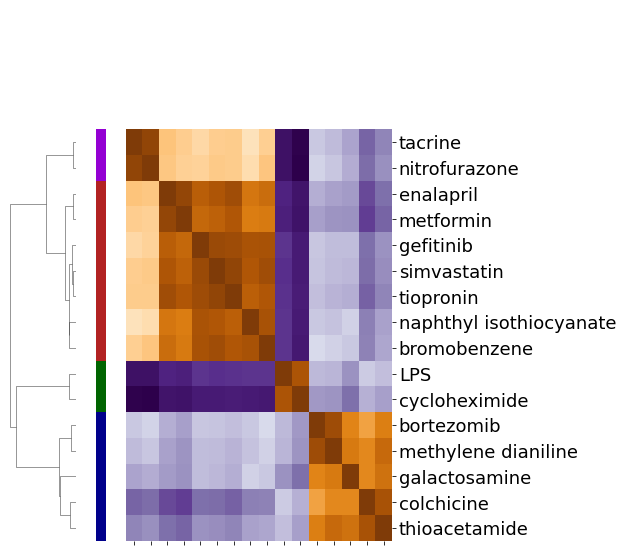

In [20]:
col=[
    "tacrine","nitrofurazone",
    "enalapril","metformin","gefitinib","simvastatin","tiopronin",
    "naphthyl isothiocyanate","bromobenzene",
    "LPS","cycloheximide",
    "bortezomib","methylene dianiline","galactosamine","colchicine","thioacetamide",
    ]
plot_cluster(df_time, meta_distances, lst_cluster, col, figname=f"{root}/figures/fig4b.png")

## Transcript Clustering

In [7]:
clusters = [
    ["naphthyl isothiocyanate","gefitinib",],
    ["simvastatin","enalapril","nitrofurazone","tiopronin","tacrine",],
    ["cycloheximide","bortezomib","colchicine","LPS",],
    ["bromobenzene","metformin","galactosamine","methylene dianiline","thioacetamide",],
]
col=[
    "naphthyl isothiocyanate","gefitinib",
    "simvastatin","enalapril","nitrofurazone","tiopronin","tacrine",
    "cycloheximide","bortezomib","colchicine","LPS",
    "bromobenzene","metformin","galactosamine","methylene dianiline","thioacetamide",
    ]

In [8]:
df_t = load_transcriptome(target_compounds)
df_time = create_table(df_t.T, target_compounds, preprocessing=z_conv)
df_time = df_time.loc[clusters[0]+clusters[1]+clusters[2]+clusters[3],:]
lst_cluster=[0]*len(clusters[0])+[1]*len(clusters[1])+[2]*len(clusters[2])+[3]*len(clusters[3])

In [9]:
meta_visualization, meta_distances = meta_viz_calc(df_time)

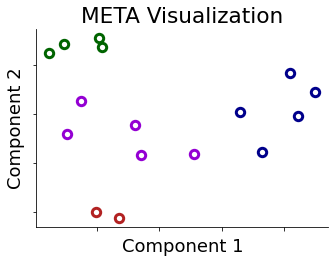

In [10]:
plot_meta(df_time, meta_visualization, lst_cluster, figname=f"{root}/figures/fig4c.png")

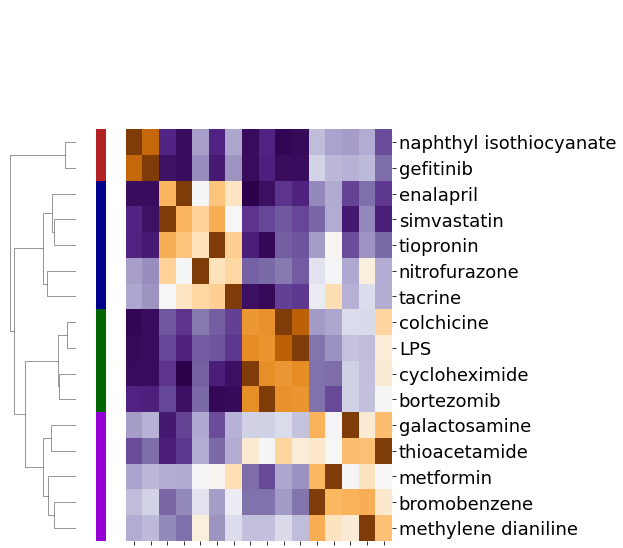

In [16]:
color_cluster=["firebrick", "darkblue", "darkgreen", "darkviolet"]
lst_cluster_t = dict()
for i, c in enumerate(clusters):
    for v in c:
        lst_cluster_t[v]=i
plot_cluster(df_time, meta_distances, lst_cluster, col, figname=f"{root}/figures/fig4d.png")